In [10]:
!pip install requests pandas numpy geopandas seaborn matplotlib

In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Memory

In [2]:
cachedir = './joblib_cache'
memory = Memory(cachedir, verbose=0)

In [3]:
API_key = '57c26501ddcc34b05931d602c9bde30020f36ab4'
raw_data_dir = "../data/raw/"
processed_data_dir = "../data/processed/"

# Economic Indicators

In [4]:
@memory.cache
def acs_df_request(params: dict, year: tuple, filename: str) -> pd.DataFrame:
    all_data = []
    
    for year in np.arange(*year):
        url = f'https://api.census.gov/data/{year}/acs/acs5'
        response = requests.get(url, params=params)
        data = response.json()
        df = pd.DataFrame(data[1:], columns = data[0])
        df['year'] = year
        all_data.append(df)
    
    acs_df = pd.concat(all_data, ignore_index = True)
    acs_df.to_csv(raw_data_dir + filename)
    return acs_df

In [7]:
#iterates through ac5 data,
# I am filtering through Oregon and cities
params = {
    'get': 'NAME,B19013_001E',
    'for': 'place:*',
    'in': 'state:41',
    'key': API_key}
acs_df = acs_df_request(params, (2013, 2024), "acs-2013-2023-oregon-cities-income.csv")
acs_df.tail()

,NAME,B19013_001E,state,place,year
4342,"Woodburn city, Oregon",67469,41,83750,2023
4343,"Wood Village city, Oregon",72404,41,83950,2023
4344,"Yachats city, Oregon",70000,41,84200,2023
4345,"Yamhill city, Oregon",121250,41,84250,2023
4346,"Yoncalla city, Oregon",55000,41,84600,2023


In [8]:
#data cleaning

#Im renaming the column name to median household income in the past 12months
median_household = acs_df.rename(columns = {'B19013_001E':'Median Household Income'})
median_household.head(5)

#im turning median income into integers since they're strings
median_household['Median Household Income'] = pd.to_numeric(median_household['Median Household Income'], errors ='coerce')
median_household['year'] = pd.to_numeric(median_household['year'], errors ='coerce')

#getting rid of na values or negative values
invalid_count = (median_household['Median Household Income'] <= 0).sum()
total_count = len(median_household)
print(f"Invalid values: {invalid_count} ({invalid_count / total_count:.2%} of total)")

median_household = median_household[median_household['Median Household Income'] > 0]

#grouping by year to get avg income over time (Hermiston city)
median_household_herm = median_household[median_household['NAME'] == 'Hermiston city, Oregon']
#grouped_herm = median_household_herm.groupby('year')[['Median Household Income']].mean()
#grouped_herm = grouped_herm.reset_index()
grouped_herm = median_household_herm

#grouping by year to get avg income over time (Klamath Falls-near site)
median_household_kla = median_household[median_household['NAME'] == 'Klamath Falls city, Oregon']
#grouped_kla = median_household_kla.groupby('year')[['Median Household Income']].mean()
#grouped_kla = grouped_kla.reset_index()
grouped_kla = median_household_kla

Invalid values: 346 (7.96% of total)


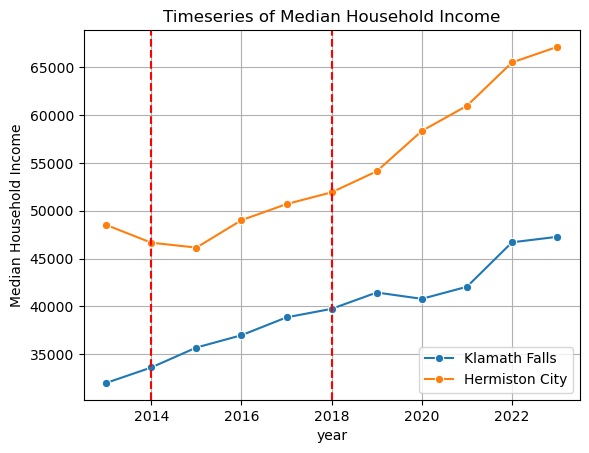

In [144]:
sns.lineplot(data = grouped_kla, x = 'year', y = 'Median Household Income', marker = 'o', label = 'Klamath Falls')
sns.lineplot(data = grouped_herm, x = 'year', y = 'Median Household Income', marker = 'o', label = 'Hermiston City')

plt.title('Timeseries of Median Household Income')
plt.legend()
plt.grid(True)
plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/city-comparison-income-2013-2023-plot.jpeg")
plt.show()

# Demographic Indicators

In [12]:
#iterates through ac5 data,
# I am filtering through Oregon and cities

params_ethnicity = {
    'get': 'NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E',
    'for': 'place:*',
    'in': 'state:41',
    'key': API_key}

ethnicity_df = acs_df_request(params_ethnicity, (2013, 2024), "acs-2013-2023-oregon-cities-ethnicity.csv")
ethnicity_df.tail()

,NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E,state,place,year
4342,"Woodburn city, Oregon",26845,16813,13209,84,241,41,83750,2023
4343,"Wood Village city, Oregon",4611,2299,2513,28,89,41,83950,2023
4344,"Yachats city, Oregon",881,34,801,5,1,41,84200,2023
4345,"Yamhill city, Oregon",1179,114,1068,0,50,41,84250,2023
4346,"Yoncalla city, Oregon",1106,40,973,0,3,41,84600,2023


In [13]:
ethnicity_df = ethnicity_df.rename(columns ={
    'B03001_001E': 'Total_Pop',
    'B03003_003E': 'Hispanic_or_Latino',
    'B02001_002E': 'White_alone',
    'B02001_003E': 'Black_alone',
    'B02001_005E': 'Asian_alone'
})

eth_column = ['Total_Pop','Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']
for i in eth_column:
    if i in ethnicity_df.columns:
        ethnicity_df[i] = pd.to_numeric(ethnicity_df[i], errors ='coerce')
ethnicity_df.to_csv(processed_data_dir + "acs-2013-2023-oregon-cities-ethnicity-processed.csv")
Klamath_falls_ethnicity = ethnicity_df[ethnicity_df['NAME'] == 'Klamath Falls city, Oregon']
Klamath_falls_ethnicity.head(5)

,NAME,Total_Pop,Hispanic_or_Latino,White_alone,Black_alone,Asian_alone,state,place,year
96,"Klamath Falls city, Oregon",21026,2811,17864,218,427,41,39700,2013
712,"Klamath Falls city, Oregon",21165,2512,18006,311,339,41,39700,2014
903,"Klamath Falls city, Oregon",21261,2852,18217,301,312,41,39700,2015
1406,"Klamath Falls city, Oregon",21322,2971,18369,275,201,41,39700,2016
1577,"Klamath Falls city, Oregon",21113,2790,18039,394,213,41,39700,2017


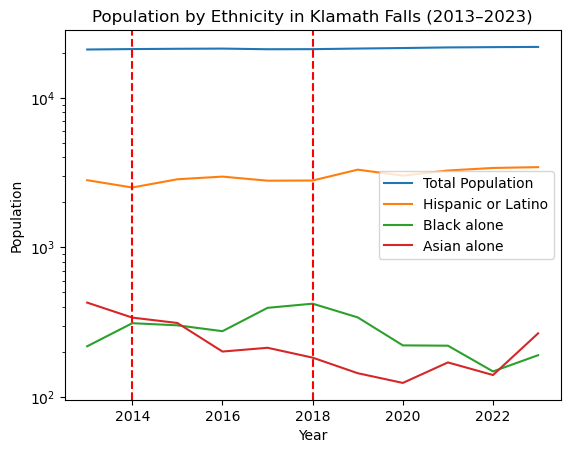

In [143]:
# ethnicity_log = np.log10(Klamath_falls_ethnicity[['Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']])
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Total_Pop', label='Total Population')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Hispanic_or_Latino',label='Hispanic or Latino')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Black_alone', label='Black alone')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Asian_alone', label='Asian alone')

plt.title('Population by Ethnicity in Klamath Falls (2013–2023)')
plt.ylabel('Population')
plt.xlabel('Year')
plt.legend()
plt.yscale('log')
plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/klamath-falls-city-ethnicity-2013-2023-plot.jpeg")
plt.show()


In [50]:
hermiston_city_ethnicity = ethnicity_df[ethnicity_df['NAME'] == "Hermiston city, Oregon"]
hermiston_city_ethnicity = hermiston_city_ethnicity.melt(id_vars="year", value_vars=["Total_Pop", "Hispanic_or_Latino", "Black_alone", "Asian_alone"])
hermiston_city_ethnicity.head()

,year,variable,value
0,2013,Total_Pop,16866
1,2014,Total_Pop,17031
2,2015,Total_Pop,17121
3,2016,Total_Pop,17150
4,2017,Total_Pop,17241


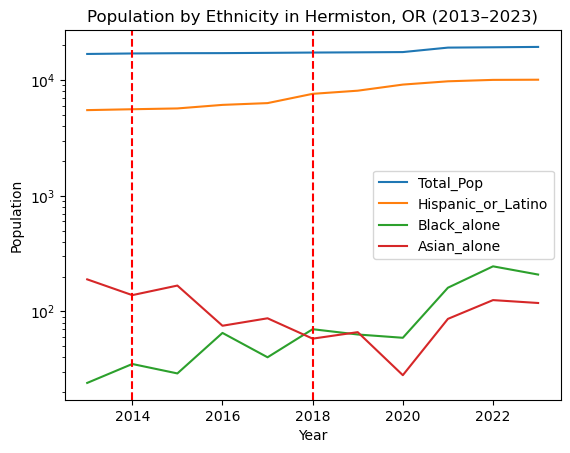

In [142]:
sns.lineplot(data=hermiston_city_ethnicity, x='year', y='value', hue='variable', legend="full")
# sns.lineplot(data=hermiston_city_ethnicity, x='year', y='Black_alone', label='Black alone')
# sns.lineplot(data=hermiston_city_ethnicity, x='year', y='Asian_alone', label='Asian alone')

plt.title('Population by Ethnicity in Hermiston, OR (2013–2023)')
plt.ylabel('Population')
plt.xlabel('Year')
plt.legend()
plt.yscale('log')
plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/hermiston-city-ethnicity-2013-2023-plot.jpeg")
plt.show()

# Mapping Basics

In [130]:
params_tract = {
    'get': 'GEO_ID,B19013_001E',
    'for': ['tract:*', 'county:035'],
    'in': ['state:41', 'county:035'],
    'key': API_key}
klamathCountyTractsIncome = acs_df_request(params_tract, (2023, 2024), "acs-2023-2023-oregon-tracts-035-income.csv")
klamathCountyTractsIncome.rename(columns={'B19013_001E': "median_household_income", 
                            'tract': 'TRACTCE',
                            'GEO_ID': "GEOIDFQ"},
                          inplace=True)

klamathCountyTractsIncome['median_household_income'] = pd.to_numeric(klamathCountyTractsIncome['median_household_income'], errors ='coerce')
klamathCountyTractsIncome['year'] = pd.to_numeric(klamathCountyTractsIncome['year'], errors ='coerce')


In [131]:
orTracts = gpd.read_file(
    f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_41_tract.zip"
)

In [132]:
superfund_coords = -121.746500, 42.264800

In [133]:
klamathCountyTractsIncome

,GEOIDFQ,median_household_income,state,county,TRACTCE,year
0,1400000US41035970100,58182,41,035,970100,2023
1,1400000US41035970201,34063,41,035,970201,2023
2,1400000US41035970202,52260,41,035,970202,2023
3,1400000US41035970300,71659,41,035,970300,2023
4,1400000US41035970400,93500,41,035,970400,2023
5,1400000US41035970500,54167,41,035,970500,2023
6,1400000US41035970600,64712,41,035,970600,2023
7,1400000US41035970700,68885,41,035,970700,2023
8,1400000US41035970800,67095,41,035,970800,2023
9,1400000US41035970901,107250,41,035,970901,2023


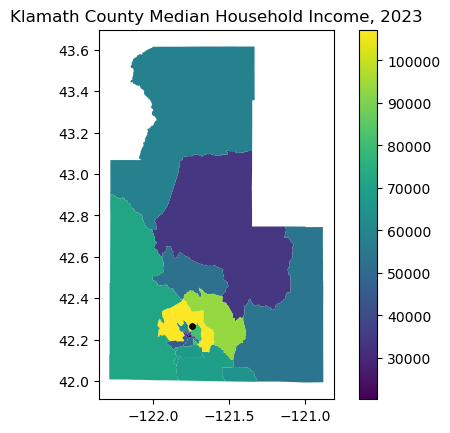

In [140]:
klamathCensusGdf = orTracts.merge(klamathCountyTractsIncome, on='GEOIDFQ', how='inner')

# Plot the result
klamathCensusGdf.plot(column="median_household_income", cmap="viridis", legend=True, categorical=False)
plt.scatter(superfund_coords[0], superfund_coords[1], s=15, c='k')
plt.title("Klamath County Median Household Income, 2023")
plt.savefig("../visualizations/klamath-county-income-2023-map.jpeg")
plt.show()

In [154]:
from shapely.geometry import Point
superfundGdf = gpd.GeoDataFrame({"Name": ["North Ridge Estates"], 'geometry': [Point(superfund_coords)]}, crs=klamathCensusGdf.crs)

m = klamathCensusGdf.explore(
    column='median_household_income',
    cmap='viridis',
    legend=True,
    # tooltip=['col1', 'col2'],
    name='Median Household Income'
)

superfundGdf.explore(
    m=m,
    column="Name",
    color="Black"
)

m
m.save("../visualizations/klamath-county-income-2023-map-folio.html")